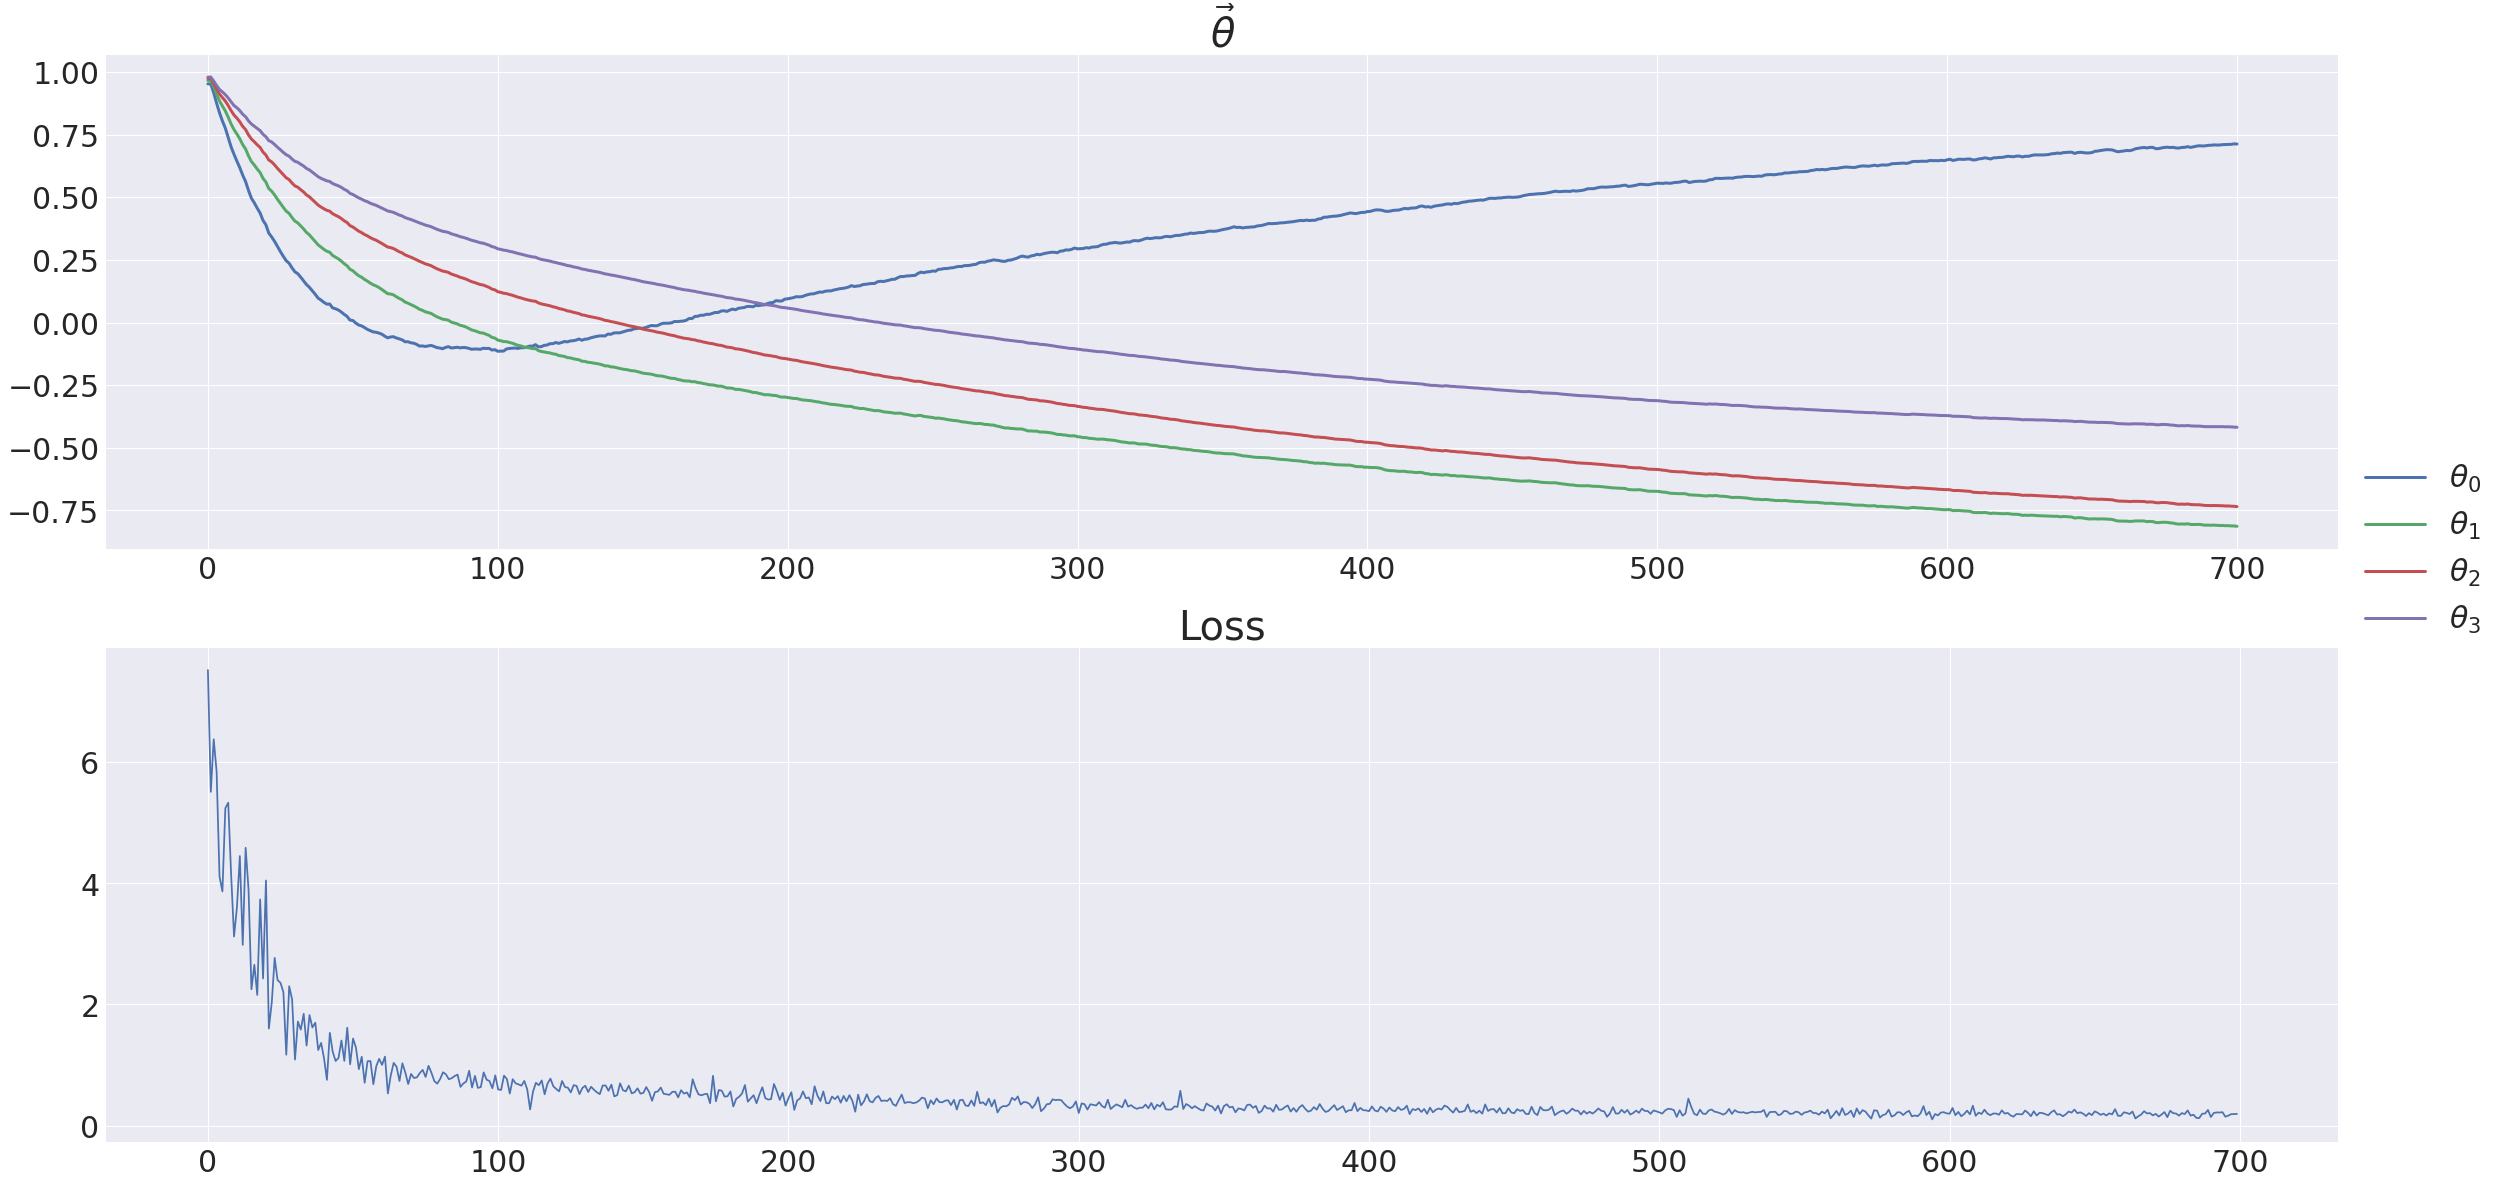

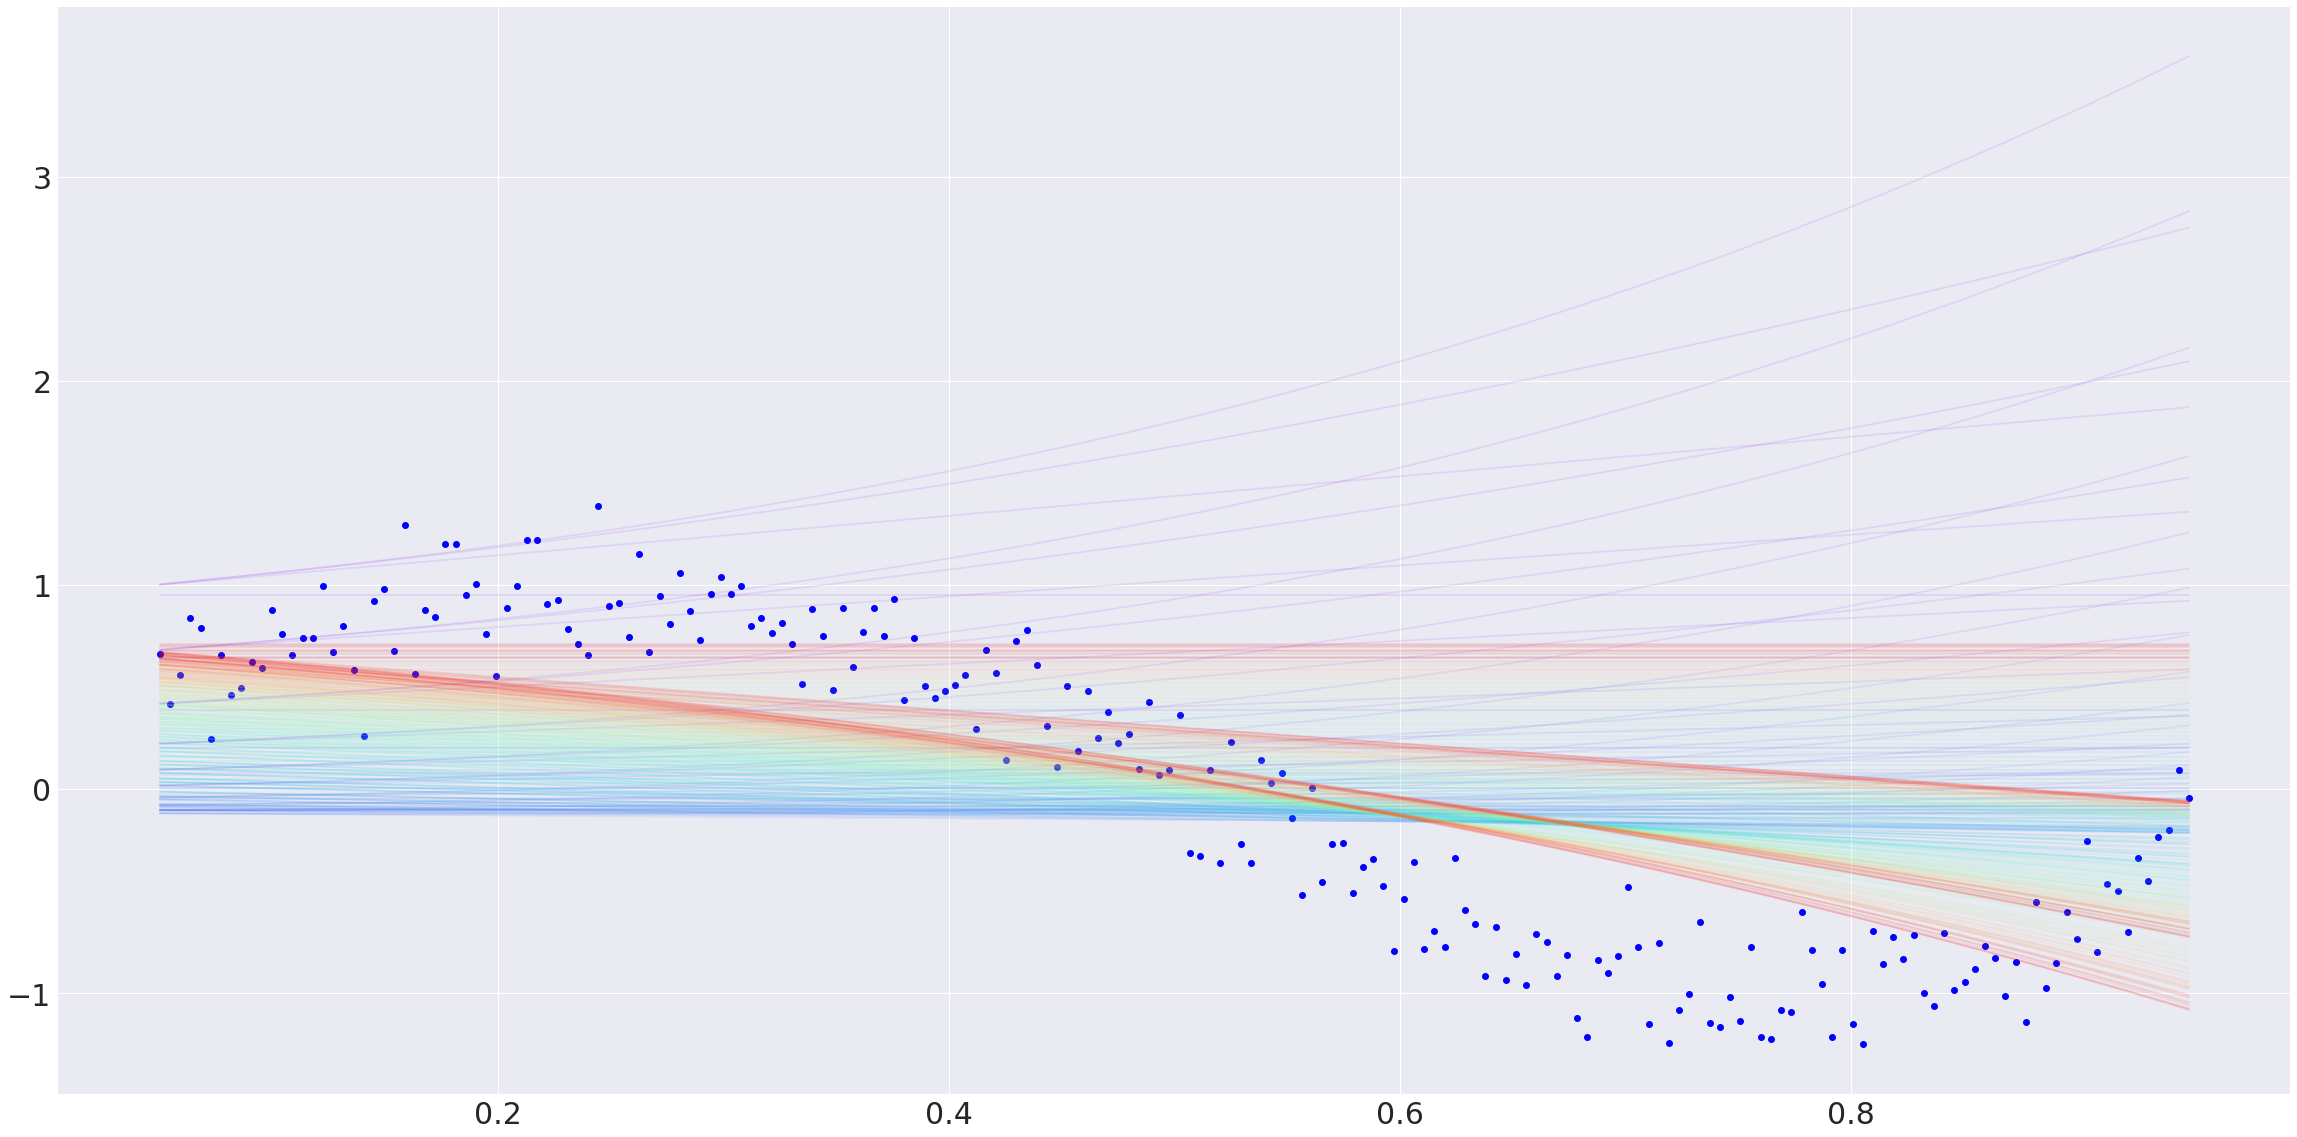

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z
    
    def backward(self, dz):
        return dz, dz
    
class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z
    
    def backward(self, dz):
        return dz, -1*dz
    
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz*self._y, dz*self._x
    
class square_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z
    
    def backward(self, dz):
        return dz*2*self._x
    
class mean_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x) 
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx
    
#---------------------------------------------------------------------------

class Affine_Function:
    def __init__(self , feature_dim, Th):
        self._feature_dim = feature_dim
        self._Th = Th
        
        self._Z1_list = [None]*(self._feature_dim + 1)
        self._Z2_list = self._Z1_list.copy() 
        self._dZ1_list, self._dZ2_list =  self._Z1_list.copy(), self._Z1_list.copy()
        self._dTh_list = self._Z1_list.copy()
        
        self.affine_imp()
        
    def affine_imp(self):
        self._node1 = [None] + [mul_node() for _ in range(self._feature_dim)]
        self._node2 = [None] + [plus_node() for _ in range(self._feature_dim)]
        
    def forward(self, X):
        for node_idx in range(1, self._feature_dim + 1):
            self._Z1_list[node_idx] = self._node1[node_idx].forward(self._Th[node_idx], X[:,node_idx])
            
        self._Z2_list[1] = self._node2[1].forward(self._Th[0], self._Z1_list[1])
        
        for node_idx in range(2, self._feature_dim + 1):
            self._Z2_list[node_idx] = self._node2[node_idx].forward(self._Z2_list[node_idx-1], self._Z1_list[node_idx])
            
        return self._Z2_list[-1]
    
    def backward(self, dZ2_last, lr):
        self._dZ2_list[-1] = dZ2_last

        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dZ2, dZ1 = self._node2[node_idx].backward(self._dZ2_list[node_idx])
            self._dZ2_list[node_idx-1] = dZ2
            self._dZ1_list[node_idx] = dZ1
    
        self._dTh_list[0] = self._dZ2_list[0]

        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dTh, _ = self._node1[node_idx].backward(self._dZ1_list[node_idx])
            self._dTh_list[node_idx] = dTh
        
        for th_idx in range(self._Th.shape[0]):
            self._Th[th_idx] = self._Th[th_idx] - lr*np.sum(self._dTh_list[th_idx])
        
        return self._Th
        
#--------------------------------------------------------------------------------------------------------

class MSE_Cost:
    def __init__(self):
        self.cost_imp()
        
    def cost_imp(self):
        self._node3 = minus_node()
        self._node4 = square_node()
        self._node5 = mean_node()
        
    def forward(self, Y, Pred):
        Z3 = self._node3.forward(Y, Pred)
        Z4 = self._node4.forward(Z3)
        J = self._node5.forward(Z4)
        return J
    
    def backward(self):
        dZ4 = self._node5.backward(1)
        dZ3 = self._node4.backward(dZ4)
        _, dZ2_last = self._node3.backward(dZ3)
        return dZ2_last
    
#---------------------------------------------------------------------------------------

def get_data_batch(data, batch_idx):
    if batch_idx is n_batch - 1:
        batch = data[batch_idx*batch_size : ]
    else:
        batch = data[batch_idx*batch_size : (batch_idx + 1)*batch_size]
    return batch

#-------------------------------------------------------------------------

plt.style.use('seaborn') 
np.random.seed(0)

n_sample = 200

h_order = 3

x_data1 = np.linspace(0.05, 1 - 0.05, n_sample).reshape(-1,1) 
y_data = np.sin(2*np.pi*x_data1) + 0.2*np.random.normal(0, 1, size = (n_sample,1))

x_data = np.zeros(shape = (n_sample, 1))

for order in range(1, h_order + 1):
    order_data = np.power(x_data1, order)    
    x_data = np.hstack((x_data, order_data)) 
data = np.hstack((x_data, y_data)) 

batch_size = 32
n_batch = np.ceil(data.shape[0]/batch_size).astype(int) 
feature_dim = x_data.shape[1]-1 
Th = np.ones(shape = (feature_dim + 1,), dtype = np.float).reshape(-1,1)

affine = Affine_Function(feature_dim, Th)
cost = MSE_Cost()

epochs, lr = 100, 0.01
th_accum = Th.reshape(-1,1) 
cost_list = [] 

for epoch in range(epochs):    
    np.random.shuffle(data)
    
    for batch_idx in range(n_batch):        
        batch = get_data_batch(data, batch_idx)        
        X, Y = batch[:,:-1], batch[:,-1] 
        
        Pred = affine.forward(X)        
        J = cost.forward(Y, Pred)
        
        dPred = cost.backward()        
        affine.backward(dPred, lr)        
        
        th_accum = np.hstack((th_accum, affine._Th))        
        cost_list.append(J)
        
fig, ax = plt.subplots(2, 1, figsize = (40,20)) 
for i in range(feature_dim + 1):    
    ax[0].plot(th_accum[i], label = r'$\theta_{%d}$'%i, linewidth = 3) 

ax[1].plot(cost_list) 
ax[0].legend(loc = 'center left', bbox_to_anchor = (1,0),fontsize = 30) 
ax[0].tick_params(axis = 'both', labelsize = 30) 
ax[1].tick_params(axis = 'both', labelsize = 30) 
ax[0].set_title(r'$\vec{\theta}$', fontsize = 40) 
ax[1].set_title('Loss', fontsize = 40)

fig, ax = plt.subplots(figsize = (40,20)) 
ax.plot(x_data1, y_data, 'bo')

cmap = cm.get_cmap('rainbow', lut = th_accum.shape[1]) 

x_range = np.linspace(np.min(x_data1), np.max(x_data1),100) 
for th_idx in range(0, th_accum.shape[1], 10):    
    pred = np.zeros(shape = x_range.shape)    
    for i in range(th_accum.shape[0]):        
        th = th_accum[i,th_idx]        
        pred += th*np.power(x_range,i)            
        
        ax.plot(x_range, pred, color = cmap(th_idx), alpha = 0.1) 

ax.tick_params(axis = 'both', labelsize = 30)


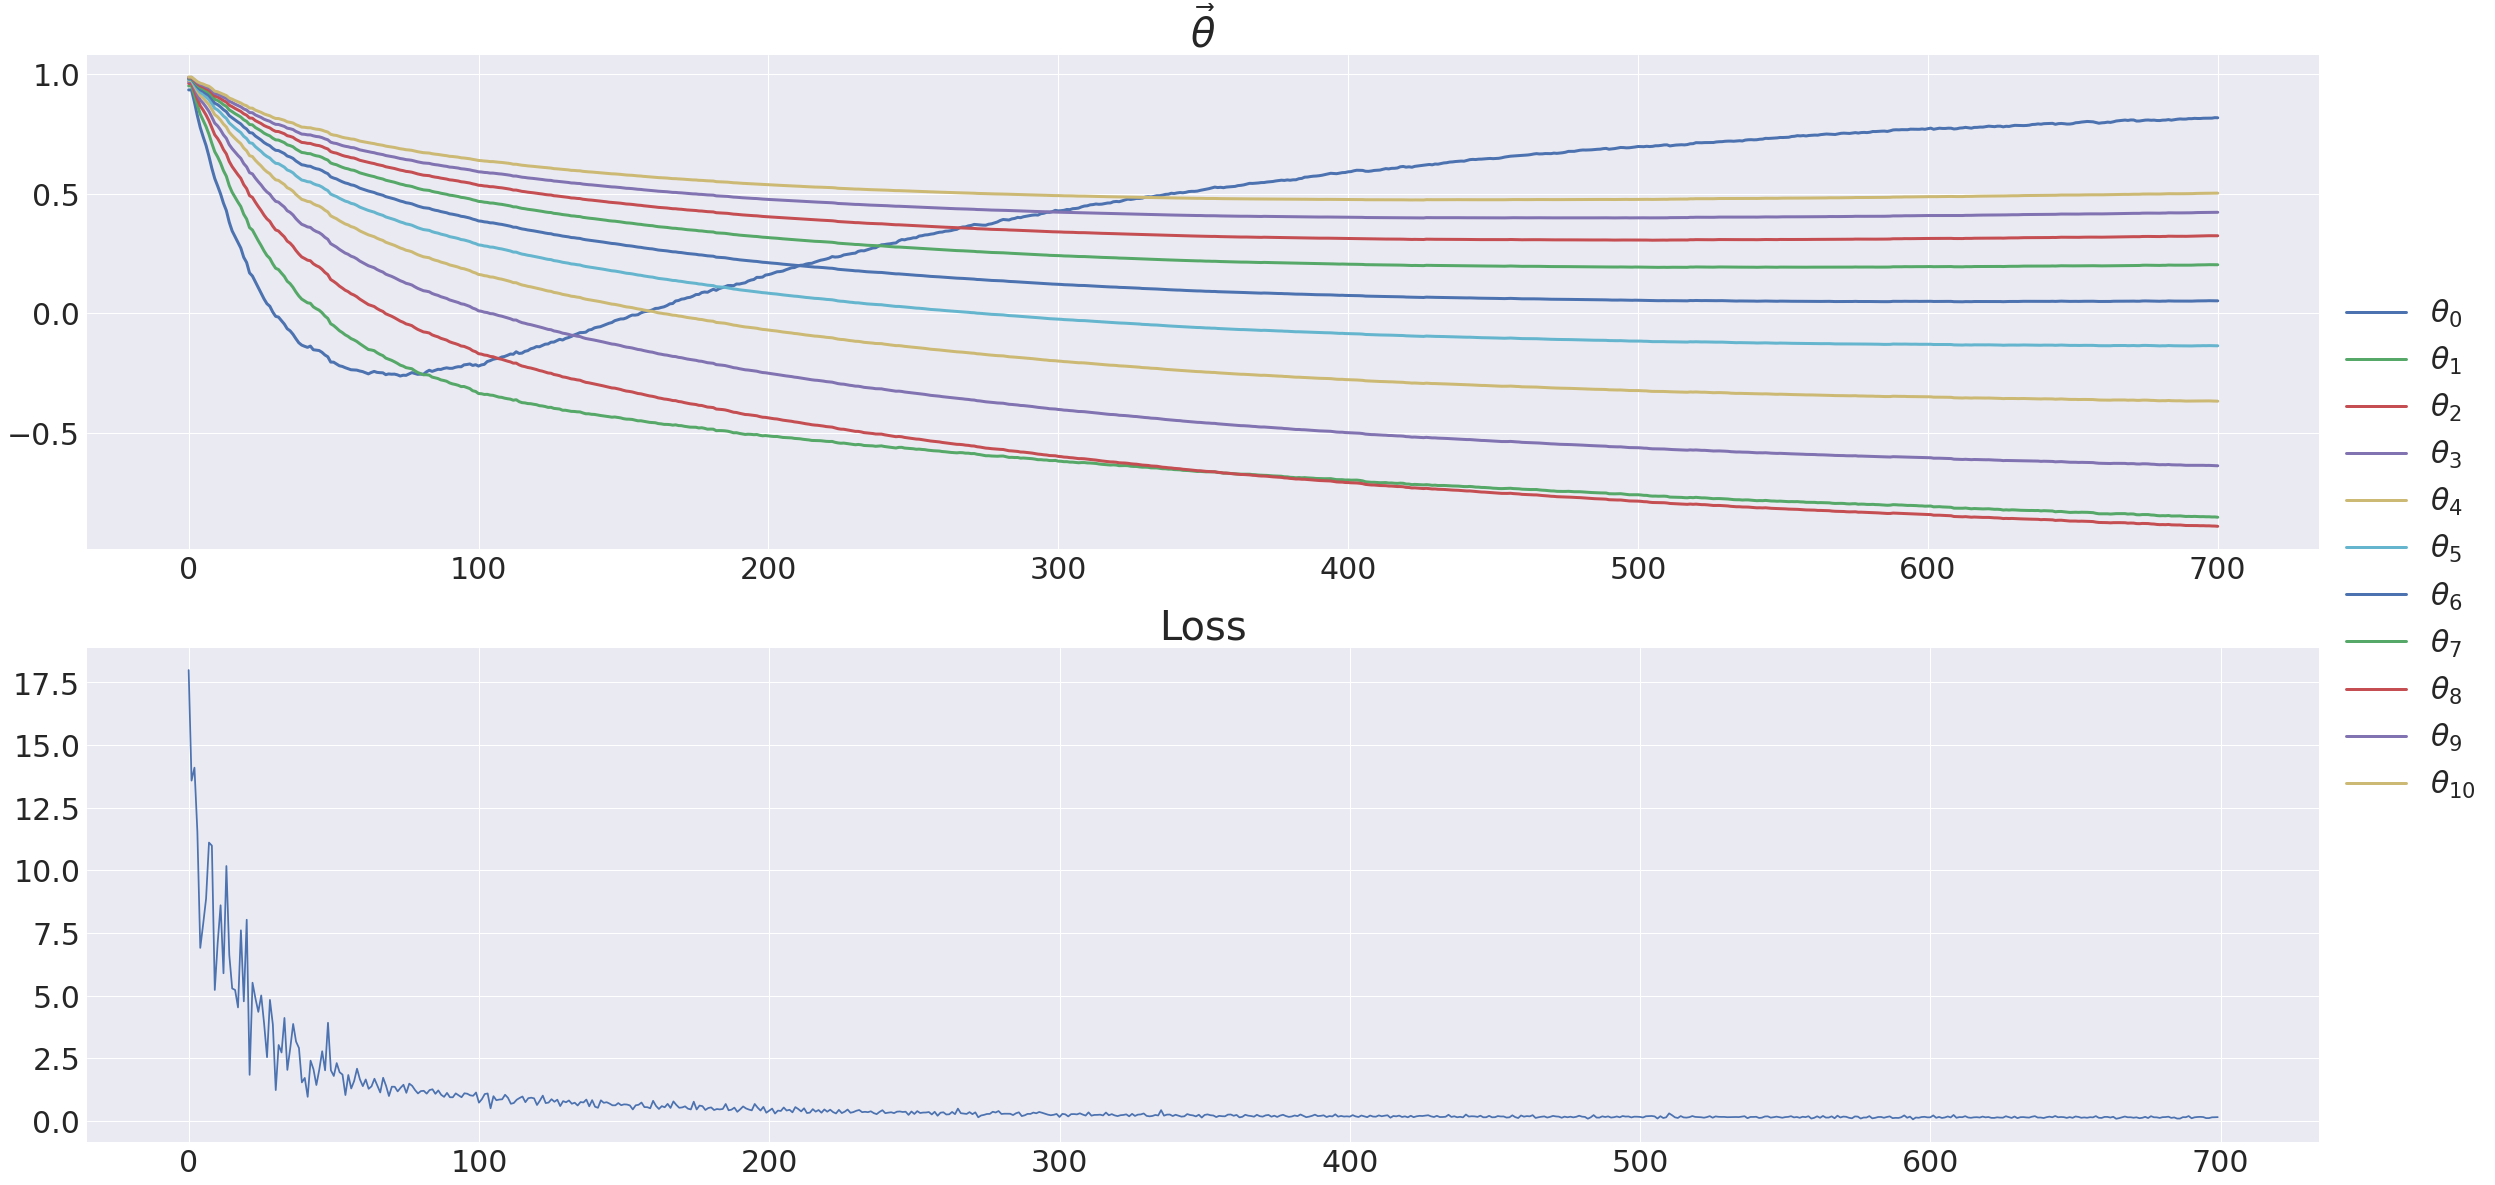

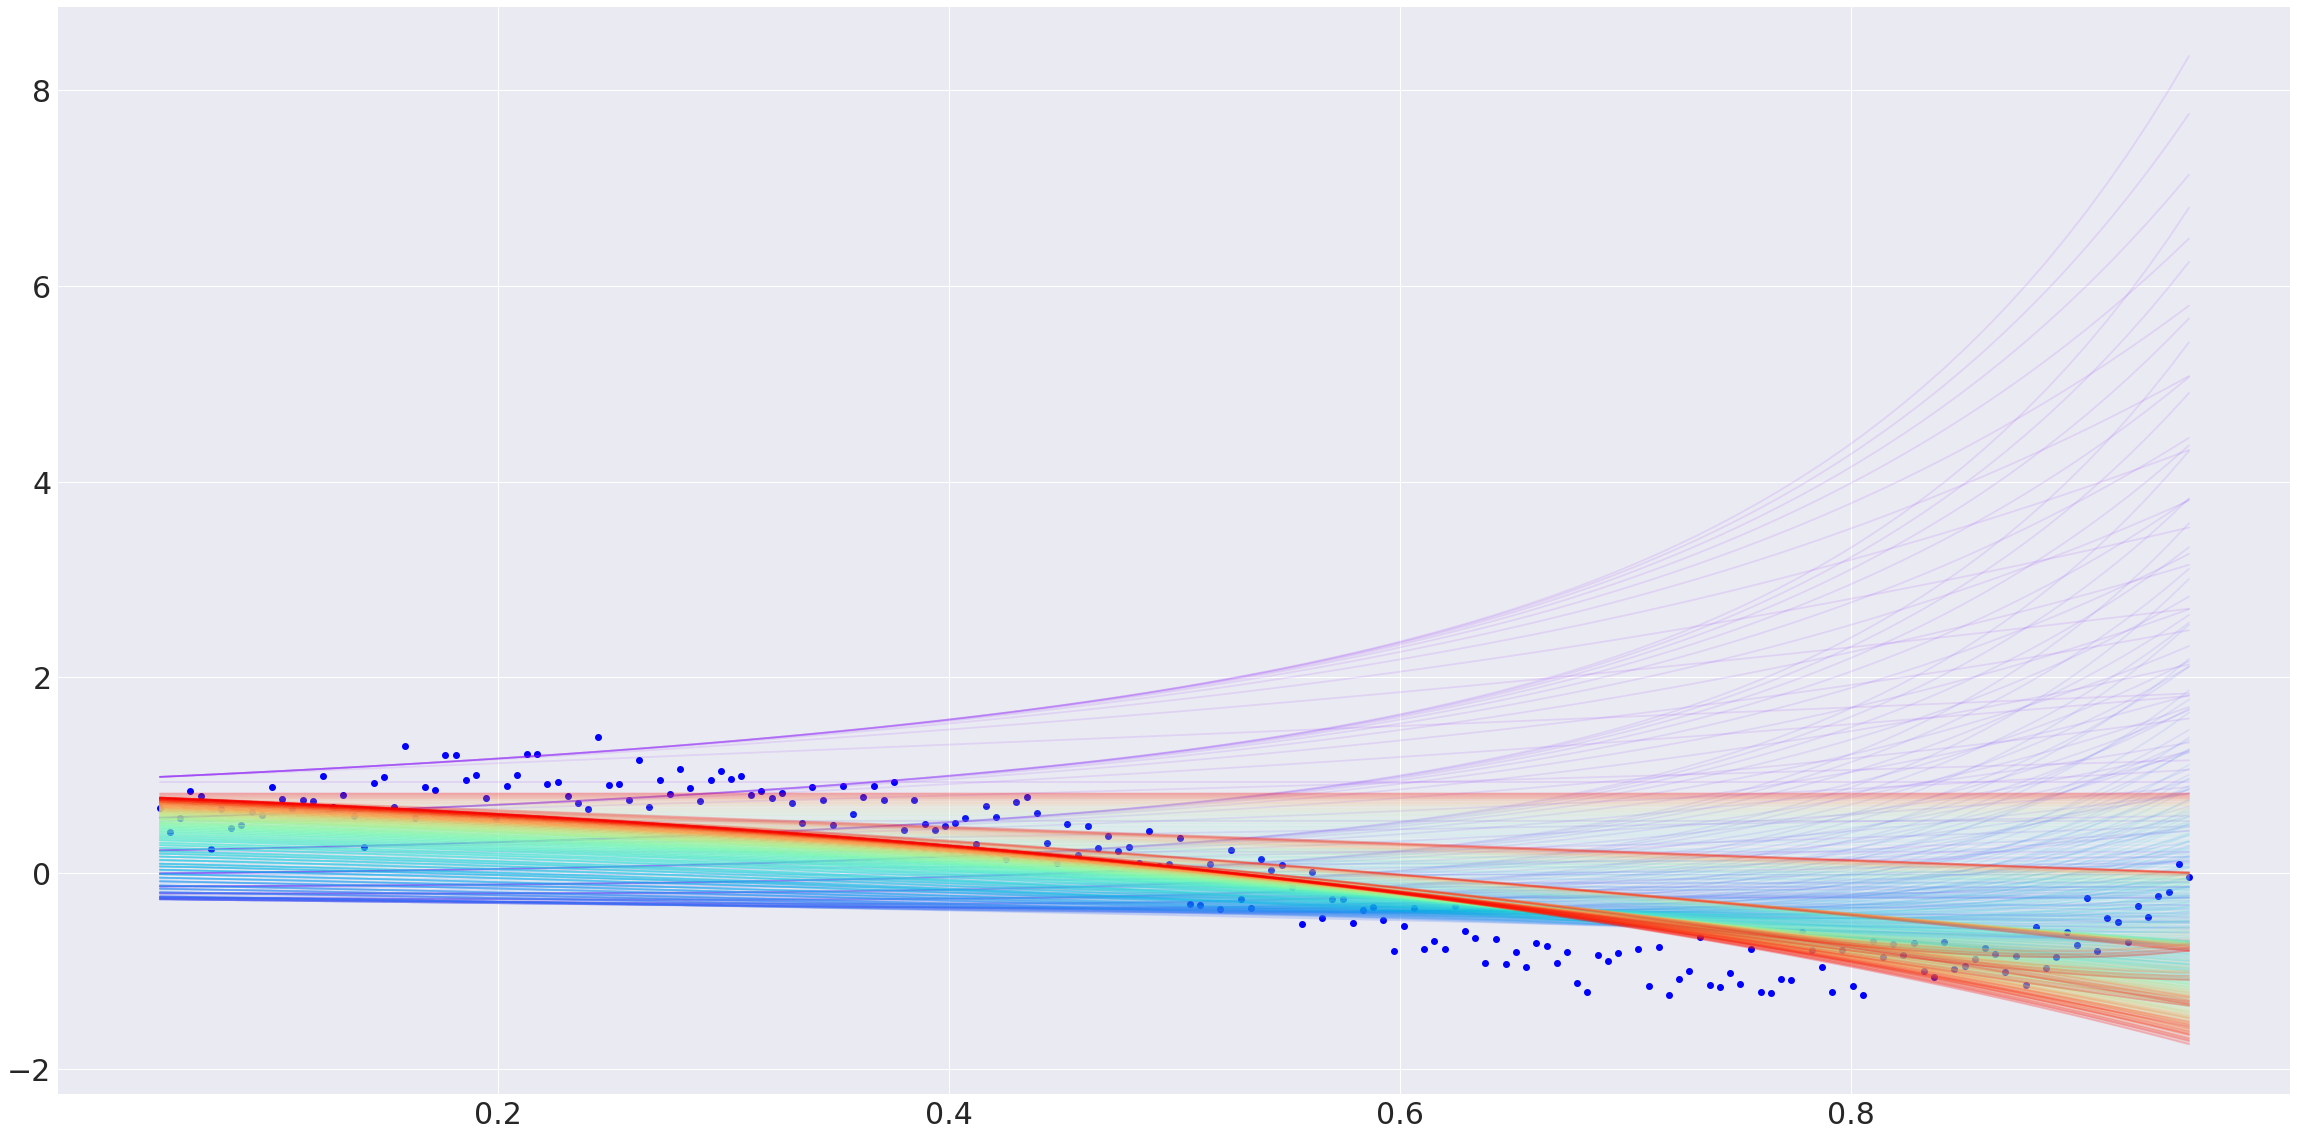

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z
    
    def backward(self, dz):
        return dz, dz
    
class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z
    
    def backward(self, dz):
        return dz, -1*dz
    
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz*self._y, dz*self._x
    
class square_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z
    
    def backward(self, dz):
        return dz*2*self._x
    
class mean_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x) 
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx
    
#---------------------------------------------------------------------------

class Affine_Function:
    def __init__(self , feature_dim, Th):
        self._feature_dim = feature_dim
        self._Th = Th
        
        self._Z1_list = [None]*(self._feature_dim + 1)
        self._Z2_list = self._Z1_list.copy() 
        self._dZ1_list, self._dZ2_list =  self._Z1_list.copy(), self._Z1_list.copy()
        self._dTh_list = self._Z1_list.copy()
        
        self.affine_imp()
        
    def affine_imp(self):
        self._node1 = [None] + [mul_node() for _ in range(self._feature_dim)]
        self._node2 = [None] + [plus_node() for _ in range(self._feature_dim)]
        
    def forward(self, X):
        for node_idx in range(1, self._feature_dim + 1):
            self._Z1_list[node_idx] = self._node1[node_idx].forward(self._Th[node_idx], X[:,node_idx])
            
        self._Z2_list[1] = self._node2[1].forward(self._Th[0], self._Z1_list[1])
        
        for node_idx in range(2, self._feature_dim + 1):
            self._Z2_list[node_idx] = self._node2[node_idx].forward(self._Z2_list[node_idx-1], self._Z1_list[node_idx])
            
        return self._Z2_list[-1]
    
    def backward(self, dZ2_last, lr):
        self._dZ2_list[-1] = dZ2_last

        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dZ2, dZ1 = self._node2[node_idx].backward(self._dZ2_list[node_idx])
            self._dZ2_list[node_idx-1] = dZ2
            self._dZ1_list[node_idx] = dZ1
    
        self._dTh_list[0] = self._dZ2_list[0]

        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dTh, _ = self._node1[node_idx].backward(self._dZ1_list[node_idx])
            self._dTh_list[node_idx] = dTh
        
        for th_idx in range(self._Th.shape[0]):
            self._Th[th_idx] = self._Th[th_idx] - lr*np.sum(self._dTh_list[th_idx])
        
        return self._Th
        
#--------------------------------------------------------------------------------------------------------

class MSE_Cost:
    def __init__(self):
        self.cost_imp()
        
    def cost_imp(self):
        self._node3 = minus_node()
        self._node4 = square_node()
        self._node5 = mean_node()
        
    def forward(self, Y, Pred):
        Z3 = self._node3.forward(Y, Pred)
        Z4 = self._node4.forward(Z3)
        J = self._node5.forward(Z4)
        return J
    
    def backward(self):
        dZ4 = self._node5.backward(1)
        dZ3 = self._node4.backward(dZ4)
        _, dZ2_last = self._node3.backward(dZ3)
        return dZ2_last
    
#---------------------------------------------------------------------------------------

def get_data_batch(data, batch_idx):
    if batch_idx is n_batch - 1:
        batch = data[batch_idx*batch_size : ]
    else:
        batch = data[batch_idx*batch_size : (batch_idx + 1)*batch_size]
    return batch

#-------------------------------------------------------------------------

plt.style.use('seaborn') 
np.random.seed(0)

n_sample = 200

h_order = 10

x_data1 = np.linspace(0.05, 1 - 0.05, n_sample).reshape(-1,1) 
y_data = np.sin(2*np.pi*x_data1) + 0.2*np.random.normal(0, 1, size = (n_sample,1))

x_data = np.zeros(shape = (n_sample, 1))

for order in range(1, h_order + 1):
    order_data = np.power(x_data1, order)    
    x_data = np.hstack((x_data, order_data)) 
data = np.hstack((x_data, y_data)) 

batch_size = 32
n_batch = np.ceil(data.shape[0]/batch_size).astype(int) 
feature_dim = x_data.shape[1]-1 
Th = np.ones(shape = (feature_dim + 1,), dtype = np.float).reshape(-1,1)

affine = Affine_Function(feature_dim, Th)
cost = MSE_Cost()

epochs, lr = 100, 0.01
th_accum = Th.reshape(-1,1) 
cost_list = [] 

for epoch in range(epochs):    
    np.random.shuffle(data)
    
    for batch_idx in range(n_batch):        
        batch = get_data_batch(data, batch_idx)        
        X, Y = batch[:,:-1], batch[:,-1] 
        
        Pred = affine.forward(X)        
        J = cost.forward(Y, Pred)
        
        dPred = cost.backward()        
        affine.backward(dPred, lr)        
        
        th_accum = np.hstack((th_accum, affine._Th))        
        cost_list.append(J)
        
fig, ax = plt.subplots(2, 1, figsize = (40,20)) 
for i in range(feature_dim + 1):    
    ax[0].plot(th_accum[i], label = r'$\theta_{%d}$'%i, linewidth = 3) 

ax[1].plot(cost_list) 
ax[0].legend(loc = 'center left', bbox_to_anchor = (1,0),fontsize = 30) 
ax[0].tick_params(axis = 'both', labelsize = 30) 
ax[1].tick_params(axis = 'both', labelsize = 30) 
ax[0].set_title(r'$\vec{\theta}$', fontsize = 40) 
ax[1].set_title('Loss', fontsize = 40)

fig, ax = plt.subplots(figsize = (40,20)) 
ax.plot(x_data1, y_data, 'bo')

cmap = cm.get_cmap('rainbow', lut = th_accum.shape[1]) 

x_range = np.linspace(np.min(x_data1), np.max(x_data1),100) 
for th_idx in range(0, th_accum.shape[1], 10):    
    pred = np.zeros(shape = x_range.shape)    
    for i in range(th_accum.shape[0]):        
        th = th_accum[i,th_idx]        
        pred += th*np.power(x_range,i)            
        
        ax.plot(x_range, pred, color = cmap(th_idx), alpha = 0.1) 

ax.tick_params(axis = 'both', labelsize = 30)


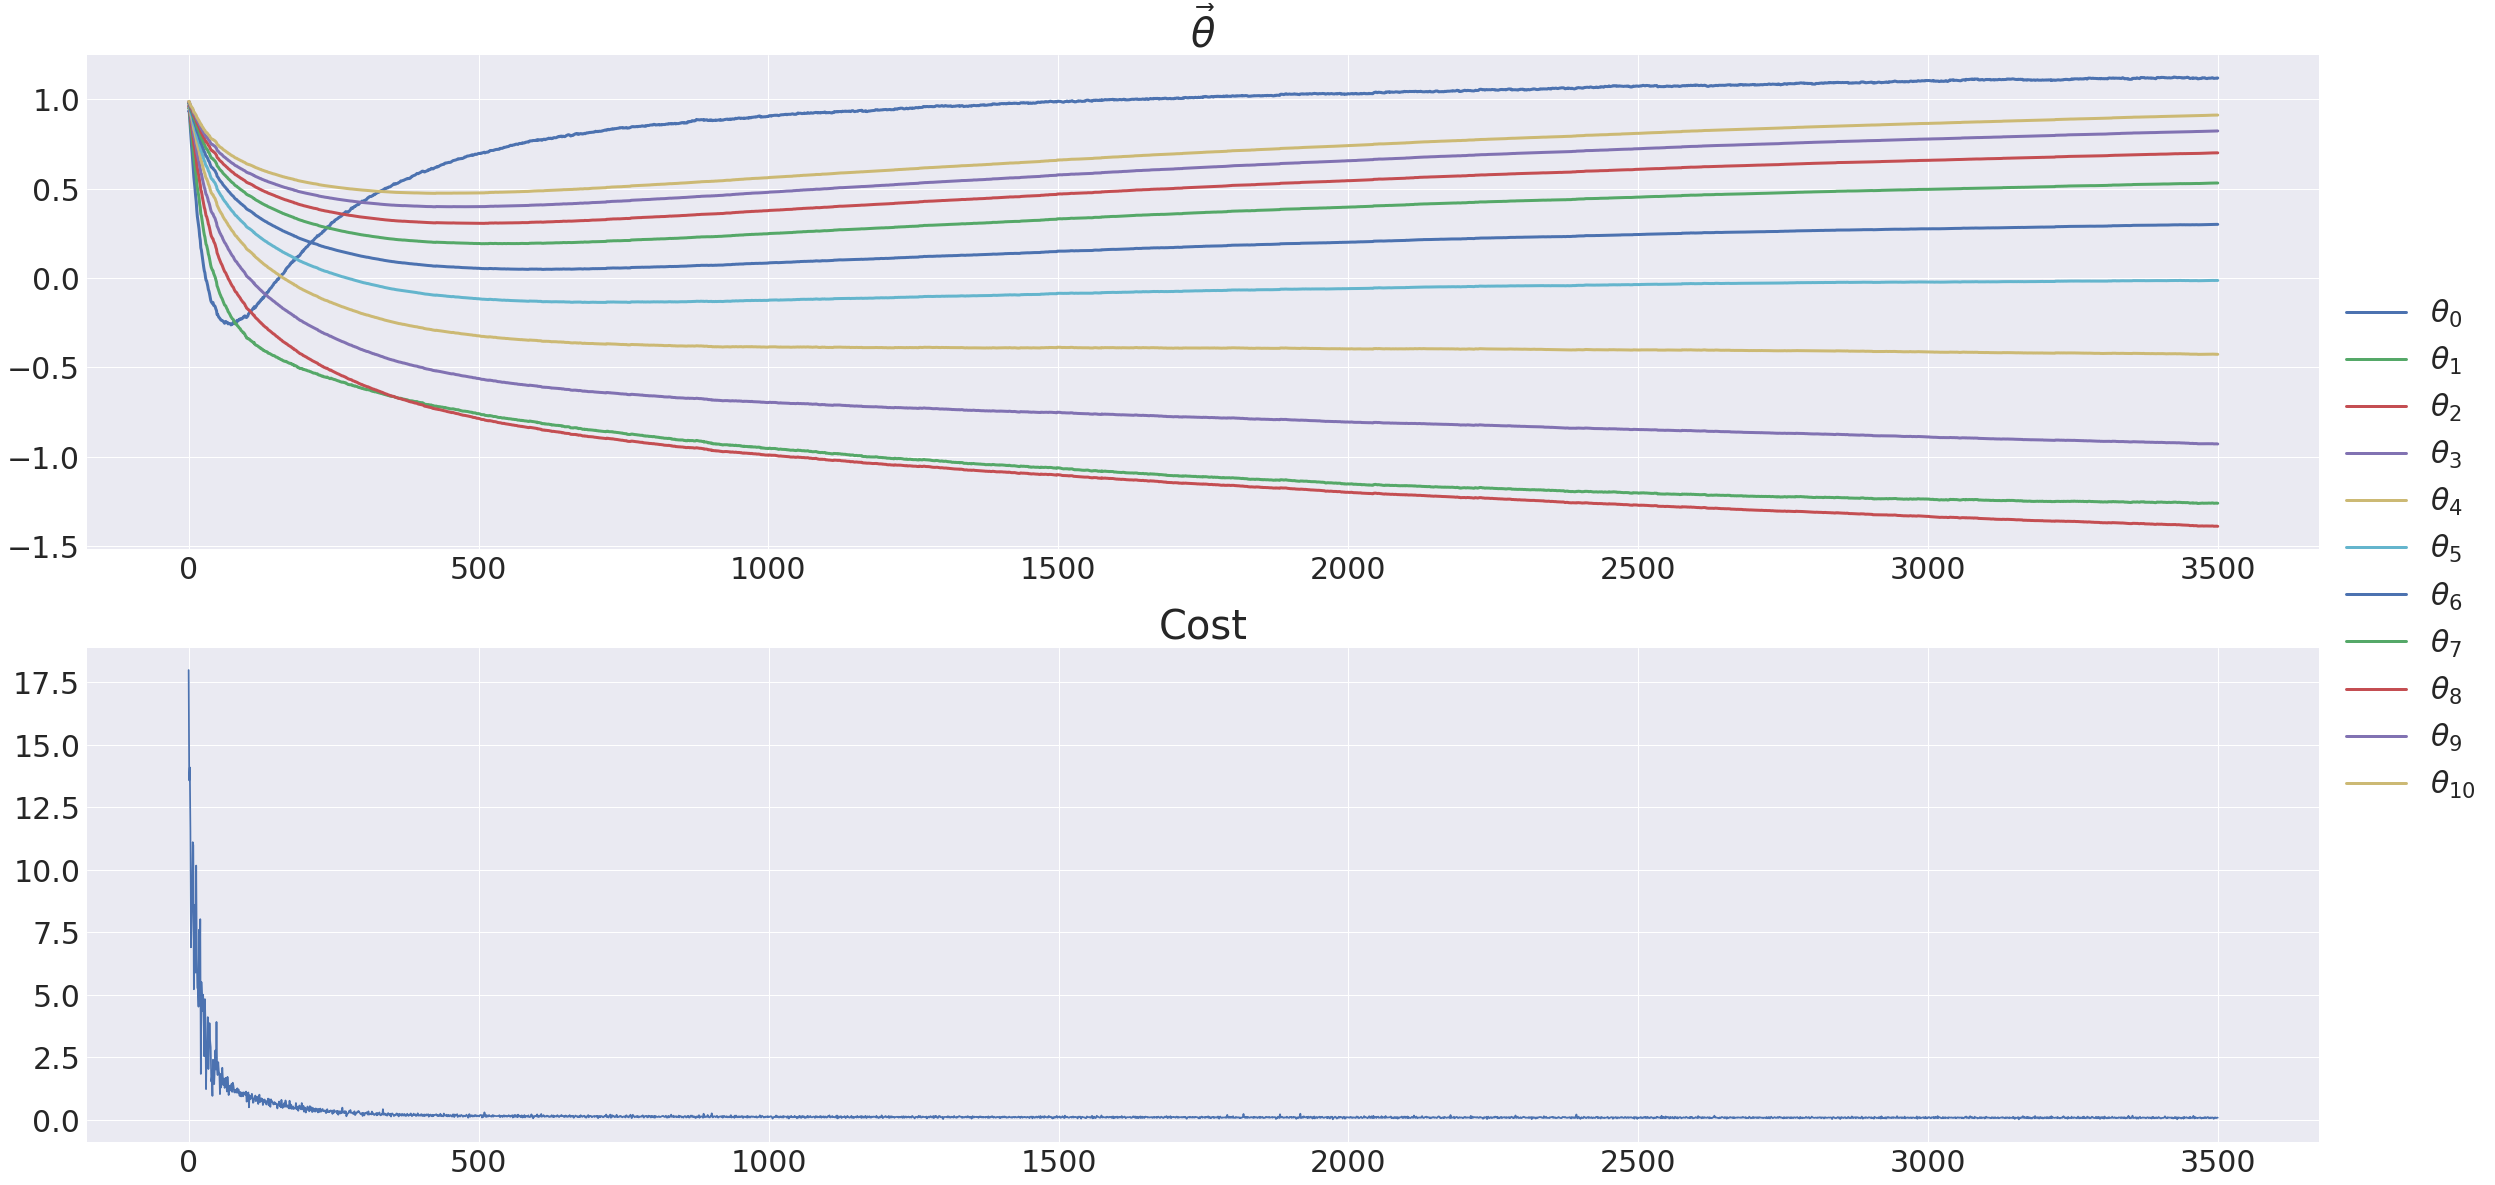

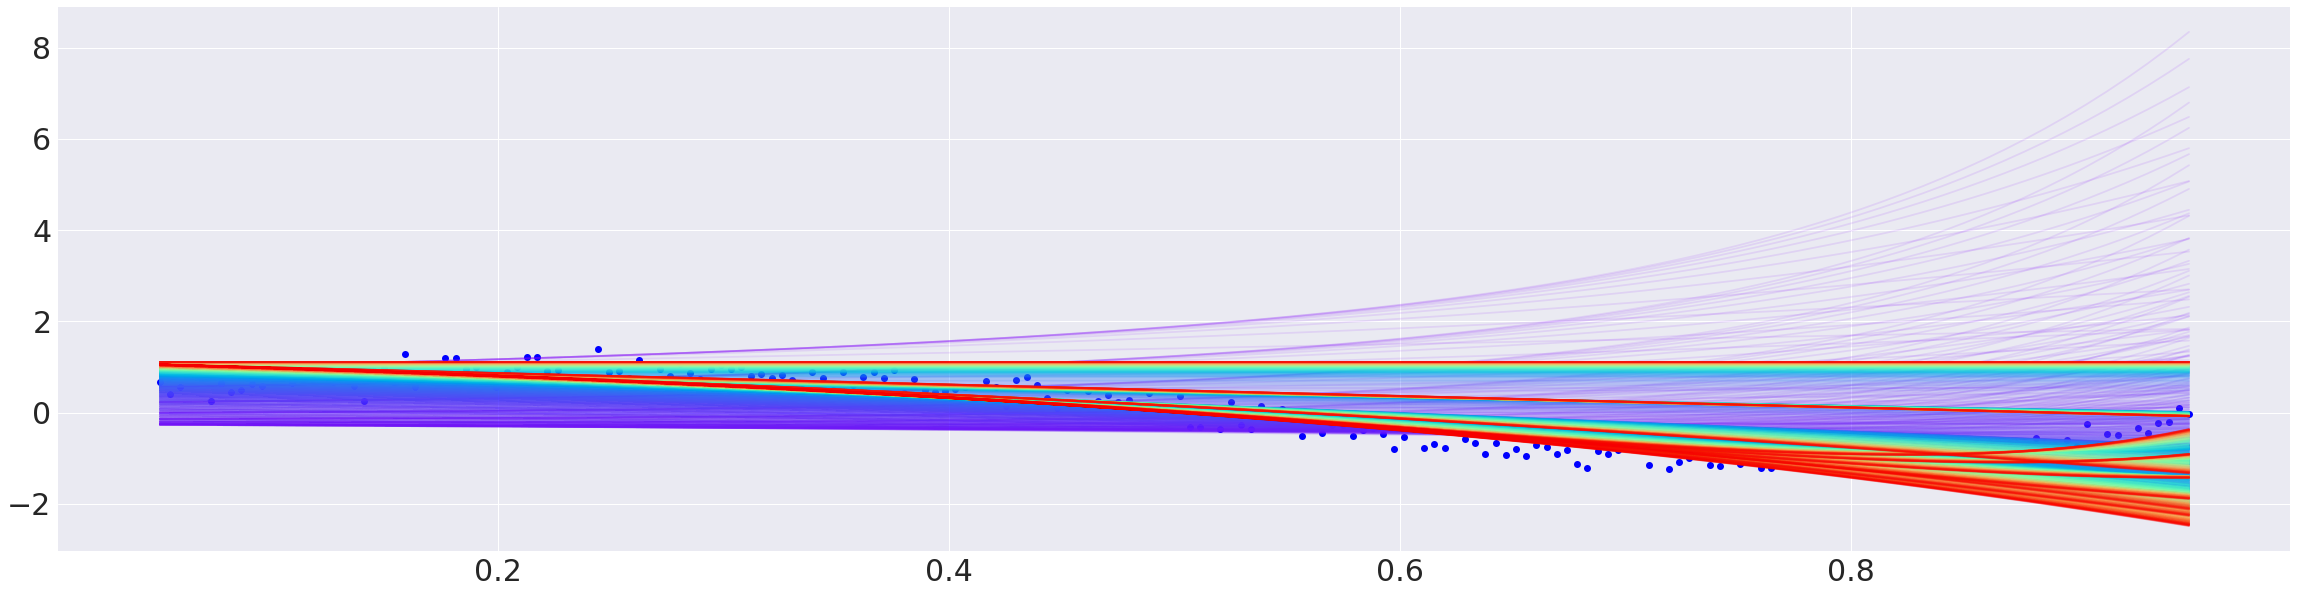

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z
    
    def backward(self, dz):
        return dz, dz
    
class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z
    
    def backward(self, dz):
        return dz, -1*dz
    
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz*self._y, dz*self._x
    
class square_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z
    
    def backward(self, dz):
        return dz*2*self._x
    
class mean_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x) 
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx
    
#---------------------------------------------------------------------------

class Affine_Function:
    def __init__(self , feature_dim, Th):
        self._feature_dim = feature_dim
        self._Th = Th
        
        self._Z1_list = [None]*(self._feature_dim + 1)
        self._Z2_list = self._Z1_list.copy() 
        self._dZ1_list, self._dZ2_list =  self._Z1_list.copy(), self._Z1_list.copy()
        self._dTh_list = self._Z1_list.copy()
        
        self.affine_imp()
        
    def affine_imp(self):
        self._node1 = [None] + [mul_node() for _ in range(self._feature_dim)]
        self._node2 = [None] + [plus_node() for _ in range(self._feature_dim)]
        
    def forward(self, X):
        for node_idx in range(1, self._feature_dim + 1):
            self._Z1_list[node_idx] = self._node1[node_idx].forward(self._Th[node_idx], X[:,node_idx])
            
        self._Z2_list[1] = self._node2[1].forward(self._Th[0], self._Z1_list[1])
        
        for node_idx in range(2, self._feature_dim + 1):
            self._Z2_list[node_idx] = self._node2[node_idx].forward(self._Z2_list[node_idx-1], self._Z1_list[node_idx])
            
        return self._Z2_list[-1]
    
    def backward(self, dZ2_last, lr):
        self._dZ2_list[-1] = dZ2_last

        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dZ2, dZ1 = self._node2[node_idx].backward(self._dZ2_list[node_idx])
            self._dZ2_list[node_idx-1] = dZ2
            self._dZ1_list[node_idx] = dZ1
    
        self._dTh_list[0] = self._dZ2_list[0]

        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dTh, _ = self._node1[node_idx].backward(self._dZ1_list[node_idx])
            self._dTh_list[node_idx] = dTh
        
        for th_idx in range(self._Th.shape[0]):
            self._Th[th_idx] = self._Th[th_idx] - lr*np.sum(self._dTh_list[th_idx])
        
        return self._Th
        
#--------------------------------------------------------------------------------------------------------

class MSE_Cost:
    def __init__(self):
        self.cost_imp()
        
    def cost_imp(self):
        self._node3 = minus_node()
        self._node4 = square_node()
        self._node5 = mean_node()
        
    def forward(self, Y, Pred):
        Z3 = self._node3.forward(Y, Pred)
        Z4 = self._node4.forward(Z3)
        J = self._node5.forward(Z4)
        return J
    
    def backward(self):
        dZ4 = self._node5.backward(1)
        dZ3 = self._node4.backward(dZ4)
        _, dZ2_last = self._node3.backward(dZ3)
        return dZ2_last
    
#---------------------------------------------------------------------------------------

def get_data_batch(data, batch_idx):
    if batch_idx is n_batch - 1:
        batch = data[batch_idx*batch_size : ]
    else:
        batch = data[batch_idx*batch_size : (batch_idx + 1)*batch_size]
    return batch

#-------------------------------------------------------------------------

plt.style.use('seaborn') 
np.random.seed(0)

n_sample = 200

h_order = 10

x_data1 = np.linspace(0.05, 1 - 0.05, n_sample).reshape(-1,1) 
y_data = np.sin(2*np.pi*x_data1) + 0.2*np.random.normal(0, 1, size = (n_sample,1))

x_data = np.zeros(shape = (n_sample, 1))

for order in range(1, h_order + 1):
    order_data = np.power(x_data1, order)    
    x_data = np.hstack((x_data, order_data)) 
data = np.hstack((x_data, y_data)) 

batch_size = 32
n_batch = np.ceil(data.shape[0]/batch_size).astype(int) 
feature_dim = x_data.shape[1]-1 
Th = np.ones(shape = (feature_dim + 1,), dtype = np.float).reshape(-1,1)

affine = Affine_Function(feature_dim, Th)
cost = MSE_Cost()

epochs, lr = 500, 0.01
th_accum = Th.reshape(-1,1) 
cost_list = [] 

for epoch in range(epochs):    
    np.random.shuffle(data)
    
    for batch_idx in range(n_batch):        
        batch = get_data_batch(data, batch_idx)        
        X, Y = batch[:,:-1], batch[:,-1] 
        
        Pred = affine.forward(X)        
        J = cost.forward(Y, Pred)
        
        dPred = cost.backward()        
        affine.backward(dPred, lr)        
        
        th_accum = np.hstack((th_accum, affine._Th))        
        cost_list.append(J)
        
fig, ax = plt.subplots(2, 1, figsize = (40,20)) 
for i in range(feature_dim + 1):    
    ax[0].plot(th_accum[i], label = r'$\theta_{%d}$'%i, linewidth = 3) 

ax[1].plot(cost_list) 
ax[0].legend(loc = 'center left', bbox_to_anchor = (1,0),fontsize = 30) 
ax[0].tick_params(axis = 'both', labelsize = 30) 
ax[1].tick_params(axis = 'both', labelsize = 30) 
ax[0].set_title(r'$\vec{\theta}$', fontsize = 40) 
ax[1].set_title('Cost', fontsize = 40)

fig, ax = plt.subplots(figsize = (40,10)) 
ax.plot(x_data1, y_data, 'bo')

cmap = cm.get_cmap('rainbow', lut = th_accum.shape[1]) 

x_range = np.linspace(np.min(x_data1), np.max(x_data1),100) 
for th_idx in range(0, th_accum.shape[1], 10):    
    pred = np.zeros(shape = x_range.shape)    
    for i in range(th_accum.shape[0]):        
        th = th_accum[i,th_idx]        
        pred += th*np.power(x_range,i)            
        
        ax.plot(x_range, pred, color = cmap(th_idx), alpha = 0.1) 

ax.tick_params(axis = 'both', labelsize = 30)

## YoungJaeLee_AI

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z
    
    def backward(self, dz):
        return dz, dz
    
class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z
    
    def backward(self, dz):
        return dz, -1*dz
    
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz*self._y, dz*self._x
    
class square_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z
    
    def backward(self, dz):
        return dz*2*self._x
    
class mean_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x) 
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx
    
#---------------------------------------------------------------------------

class Affine_Function:
    def __init__(self , feature_dim, Th):
        self._feature_dim = feature_dim
        self._Th = Th
        
        self._Z1_list = [None]*(self._feature_dim + 1)
        self._Z2_list = self._Z1_list.copy() 
        self._dZ1_list, self._dZ2_list =  self._Z1_list.copy(), self._Z1_list.copy()
        self._dTh_list = self._Z1_list.copy()
        
        self.affine_imp()
        
    def affine_imp(self):
        self._node1 = [None] + [mul_node() for _ in range(self._feature_dim)]
        self._node2 = [None] + [plus_node() for _ in range(self._feature_dim)]
        
    def forward(self, X):
        for node_idx in range(1, self._feature_dim + 1):
            self._Z1_list[node_idx] = self._node1[node_idx].forward(self._Th[node_idx], X[:,node_idx])
            
        self._Z2_list[1] = self._node2[1].forward(self._Th[0], self._Z1_list[1])
        
        for node_idx in range(2, self._feature_dim + 1):
            self._Z2_list[node_idx] = self._node2[node_idx].forward(self._Z2_list[node_idx-1], self._Z1_list[node_idx])
            
        return self._Z2_list[-1]
    
    def backward(self, dZ2_last, lr):
        self._dZ2_list[-1] = dZ2_last

        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dZ2, dZ1 = self._node2[node_idx].backward(self._dZ2_list[node_idx])
            self._dZ2_list[node_idx-1] = dZ2
            self._dZ1_list[node_idx] = dZ1
    
        self._dTh_list[0] = self._dZ2_list[0]

        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dTh, _ = self._node1[node_idx].backward(self._dZ1_list[node_idx])
            self._dTh_list[node_idx] = dTh
        
        for th_idx in range(self._Th.shape[0]):
            self._Th[th_idx] = self._Th[th_idx] - lr*np.sum(self._dTh_list[th_idx])
        
        return self._Th
        
#--------------------------------------------------------------------------------------------------------

class MSE_Cost:
    def __init__(self):
        self.cost_imp()
        
    def cost_imp(self):
        self._node3 = minus_node()
        self._node4 = square_node()
        self._node5 = mean_node()
        
    def forward(self, Y, Pred):
        Z3 = self._node3.forward(Y, Pred)
        Z4 = self._node4.forward(Z3)
        J = self._node5.forward(Z4)
        return J
    
    def backward(self):
        dZ4 = self._node5.backward(1)
        dZ3 = self._node4.backward(dZ4)
        _, dZ2_last = self._node3.backward(dZ3)
        return dZ2_last
    
#---------------------------------------------------------------------------------------

def get_data_batch(data, batch_idx):
    if batch_idx is n_batch - 1:
        batch = data[batch_idx*batch_size : ]
    else:
        batch = data[batch_idx*batch_size : (batch_idx + 1)*batch_size]
    return batch

#-------------------------------------------------------------------------

plt.style.use('seaborn') 
np.random.seed(0)

n_sample = 200

h_order = 10

x_data1 = np.linspace(0.05, 1 - 0.05, n_sample).reshape(-1,1) 
y_data = np.sin(2*np.pi*x_data1) + 0.2*np.random.normal(0, 1, size = (n_sample,1))

x_data = np.zeros(shape = (n_sample, 1))

for order in range(1, h_order + 1):
    order_data = np.power(x_data1, order)    
    x_data = np.hstack((x_data, order_data)) 
data = np.hstack((x_data, y_data)) 

batch_size = 32
n_batch = np.ceil(data.shape[0]/batch_size).astype(int) 
feature_dim = x_data.shape[1]-1 
Th = np.ones(shape = (feature_dim + 1,), dtype = np.float).reshape(-1,1)

affine = Affine_Function(feature_dim, Th)
cost = MSE_Cost()

# Point!
epochs, lr = 1000, 0.01

th_accum = Th.reshape(-1,1) 
cost_list = [] 

for epoch in range(epochs):    
    np.random.shuffle(data)
    
    for batch_idx in range(n_batch):        
        batch = get_data_batch(data, batch_idx)        
        X, Y = batch[:,:-1], batch[:,-1] 
        
        Pred = affine.forward(X)        
        J = cost.forward(Y, Pred)
        
        dPred = cost.backward()        
        affine.backward(dPred, lr)        
        
        th_accum = np.hstack((th_accum, affine._Th))        
        cost_list.append(J)
        
fig, ax = plt.subplots(2, 1, figsize = (40,20)) 
for i in range(feature_dim + 1):    
    ax[0].plot(th_accum[i], label = r'$\theta_{%d}$'%i, linewidth = 3) 

ax[1].plot(cost_list) 
ax[0].legend(loc = 'center left', bbox_to_anchor = (1,0),fontsize = 30) 
ax[0].tick_params(axis = 'both', labelsize = 30) 
ax[1].tick_params(axis = 'both', labelsize = 30) 
ax[0].set_title(r'$\vec{\theta}$', fontsize = 40) 
ax[1].set_title('Cost', fontsize = 40)

fig, ax = plt.subplots(figsize = (40,20)) 
ax.plot(x_data1, y_data, 'bo')

cmap = cm.get_cmap('rainbow', lut = th_accum.shape[1]) 

x_range = np.linspace(np.min(x_data1), np.max(x_data1),100) 
for th_idx in range(0, th_accum.shape[1], 10):    
    pred = np.zeros(shape = x_range.shape)    
    for i in range(th_accum.shape[0]):        
        th = th_accum[i,th_idx]        
        pred += th*np.power(x_range,i)            
        
        ax.plot(x_range, pred, color = cmap(th_idx), alpha = 0.1) 

ax.tick_params(axis = 'both', labelsize = 30)